<a href="https://colab.research.google.com/github/acate/circle_counting/blob/main/detect_circles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


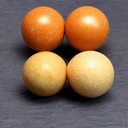

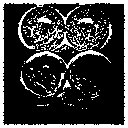

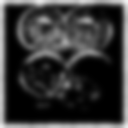

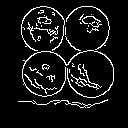

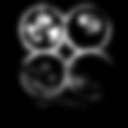

255


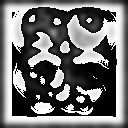

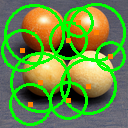

10


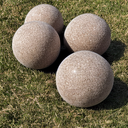

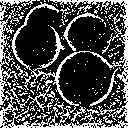

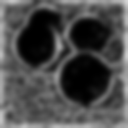

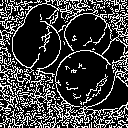

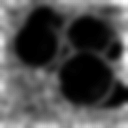

255


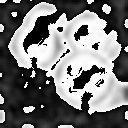

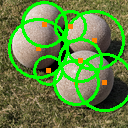

8


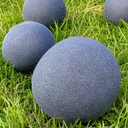

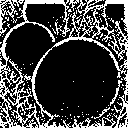

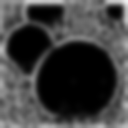

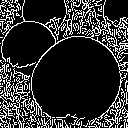

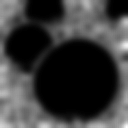

255


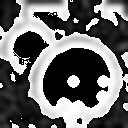

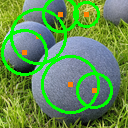

6


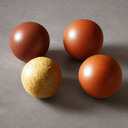

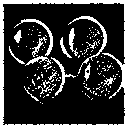

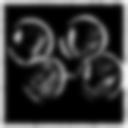

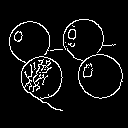

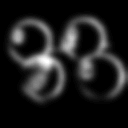

255


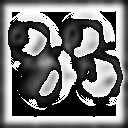

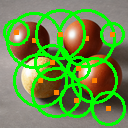

12


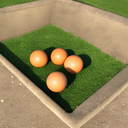

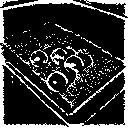

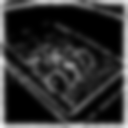

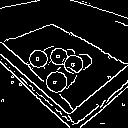

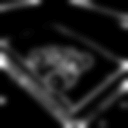

255


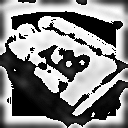

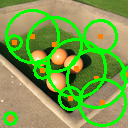

11


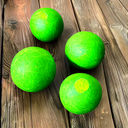

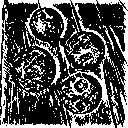

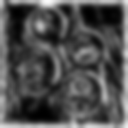

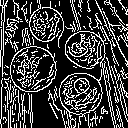

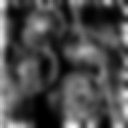

255


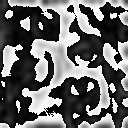

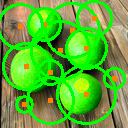

12


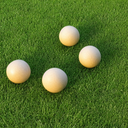

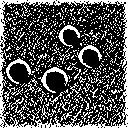

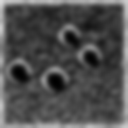

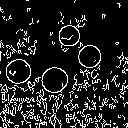

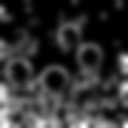

255


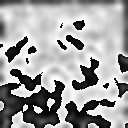

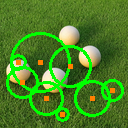

8


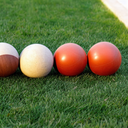

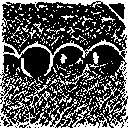

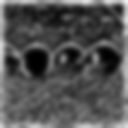

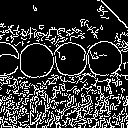

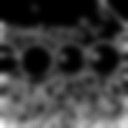

255


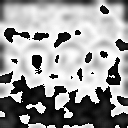

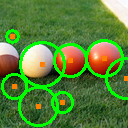

8


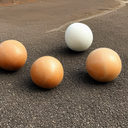

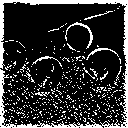

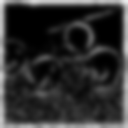

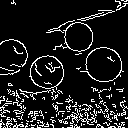

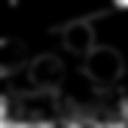

255


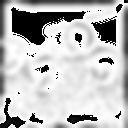

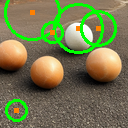

5


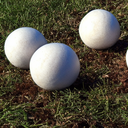

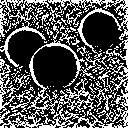

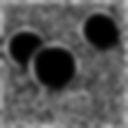

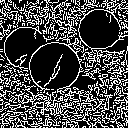

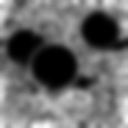

255


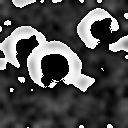

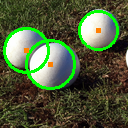

3


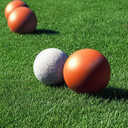

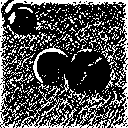

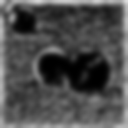

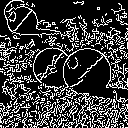

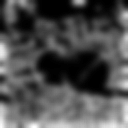

255


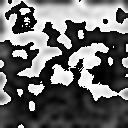

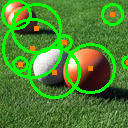

9


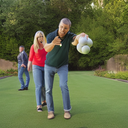

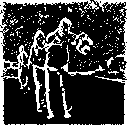

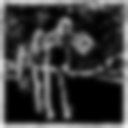

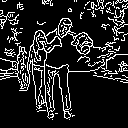

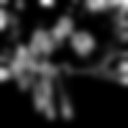

255


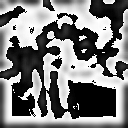

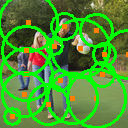

16


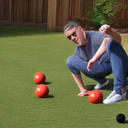

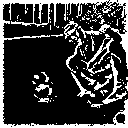

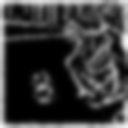

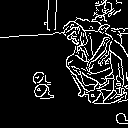

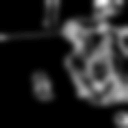

255


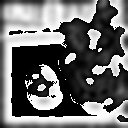

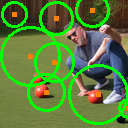

8


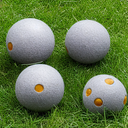

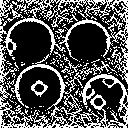

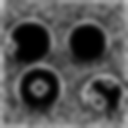

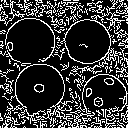

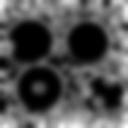

255


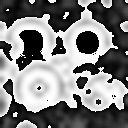

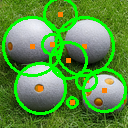

9


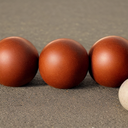

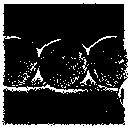

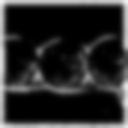

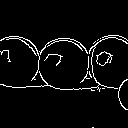

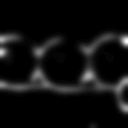

255


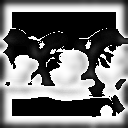

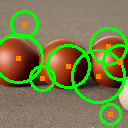

8


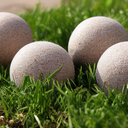

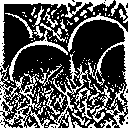

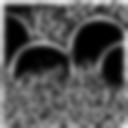

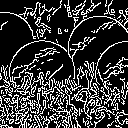

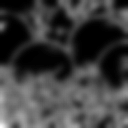

255


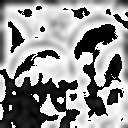

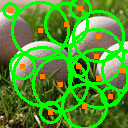

15


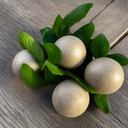

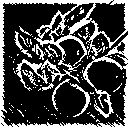

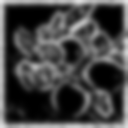

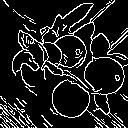

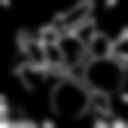

255


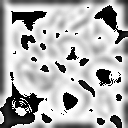

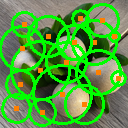

17


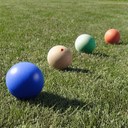

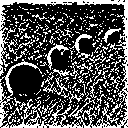

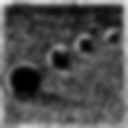

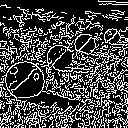

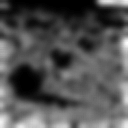

255


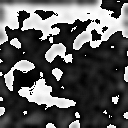

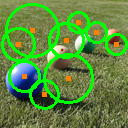

9


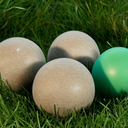

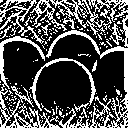

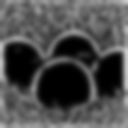

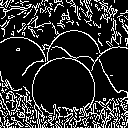

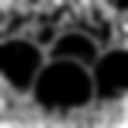

255


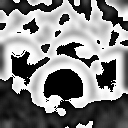

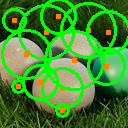

12


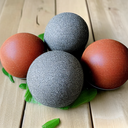

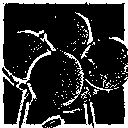

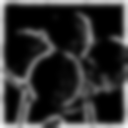

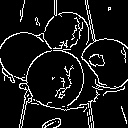

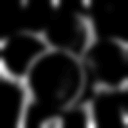

255


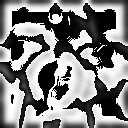

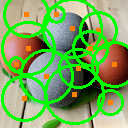

13


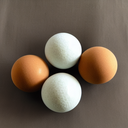

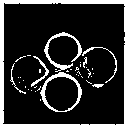

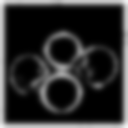

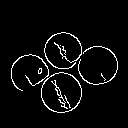

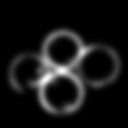

255


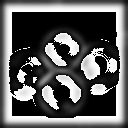

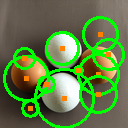

11


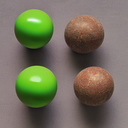

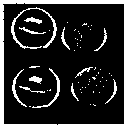

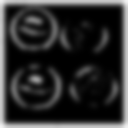

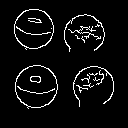

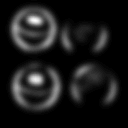

255


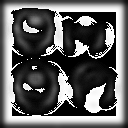

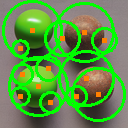

13


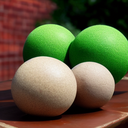

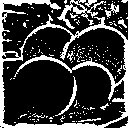

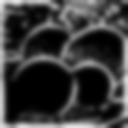

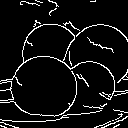

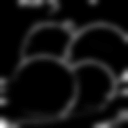

255


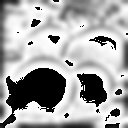

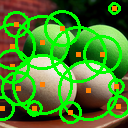

16


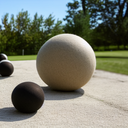

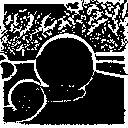

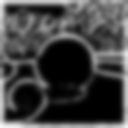

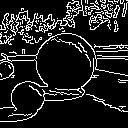

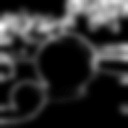

255


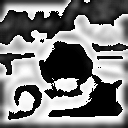

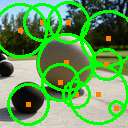

11


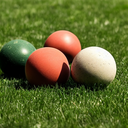

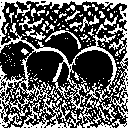

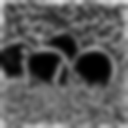

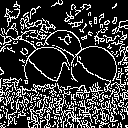

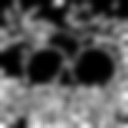

255


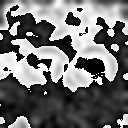

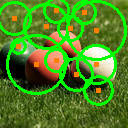

12


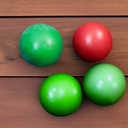

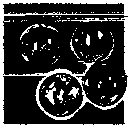

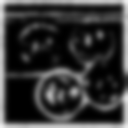

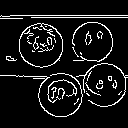

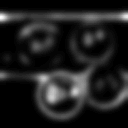

255


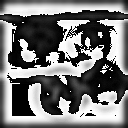

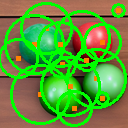

14


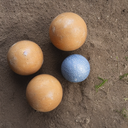

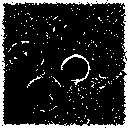

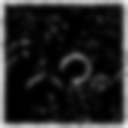

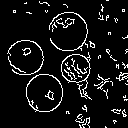

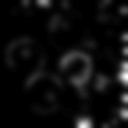

255


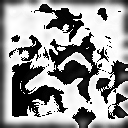

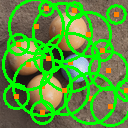

19


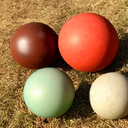

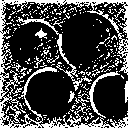

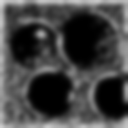

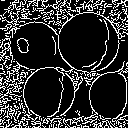

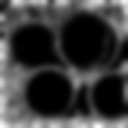

255


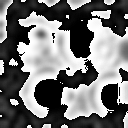

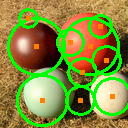

10


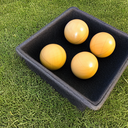

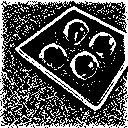

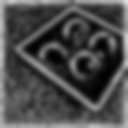

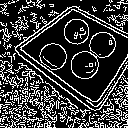

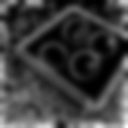

255


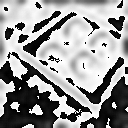

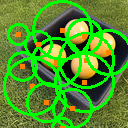

13


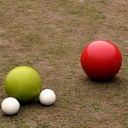

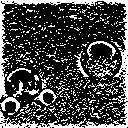

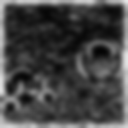

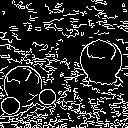

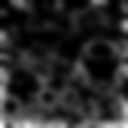

255


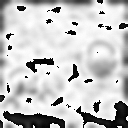

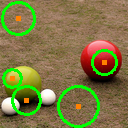

5


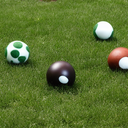

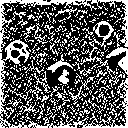

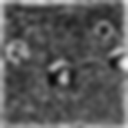

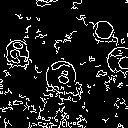

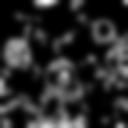

255


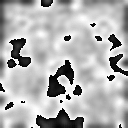

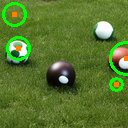

4


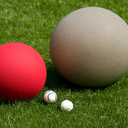

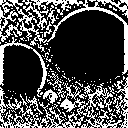

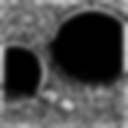

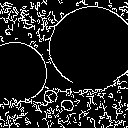

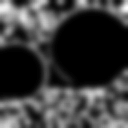

255


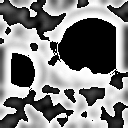

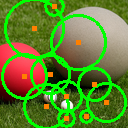

11


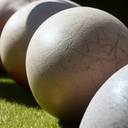

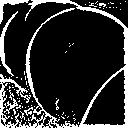

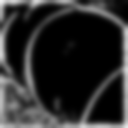

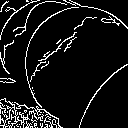

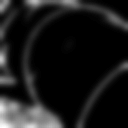

255


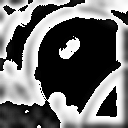

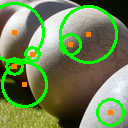

7


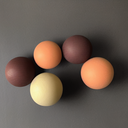

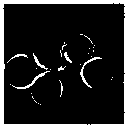

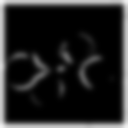

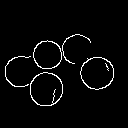

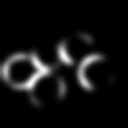

255


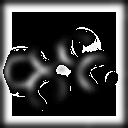

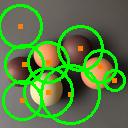

9


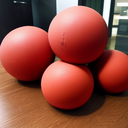

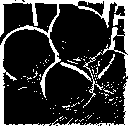

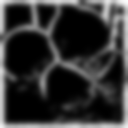

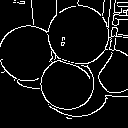

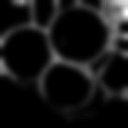

255


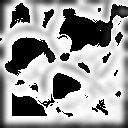

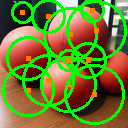

12


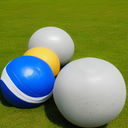

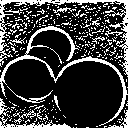

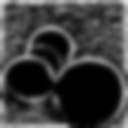

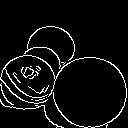

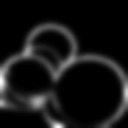

255


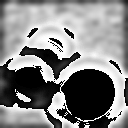

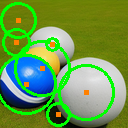

7


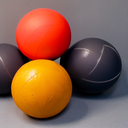

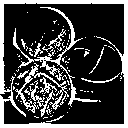

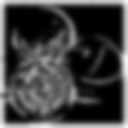

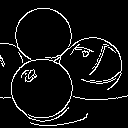

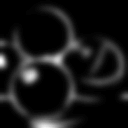

255


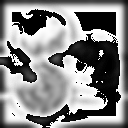

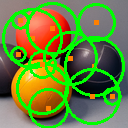

12


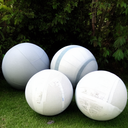

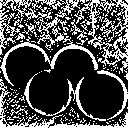

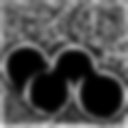

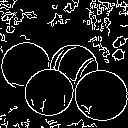

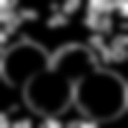

255


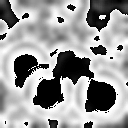

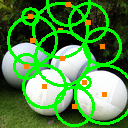

12


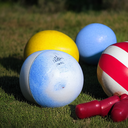

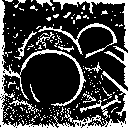

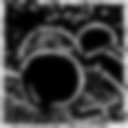

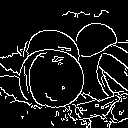

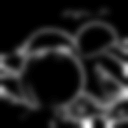

255


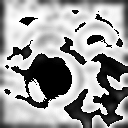

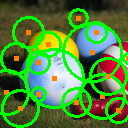

16


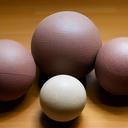

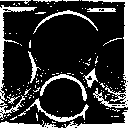

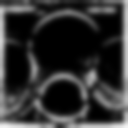

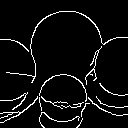

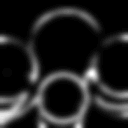

255


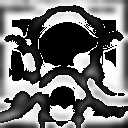

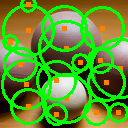

18


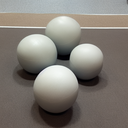

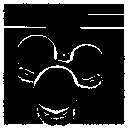

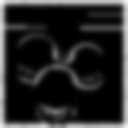

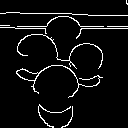

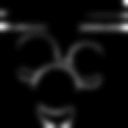

255


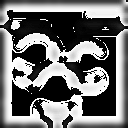

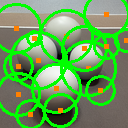

15


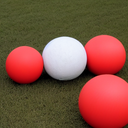

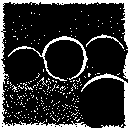

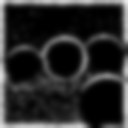

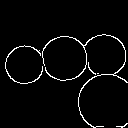

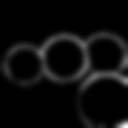

255


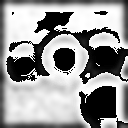

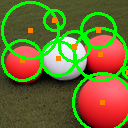

9


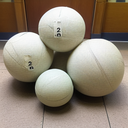

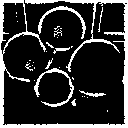

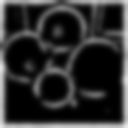

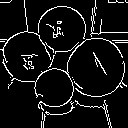

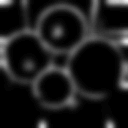

255


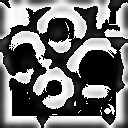

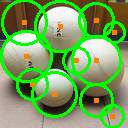

11


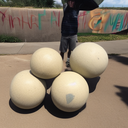

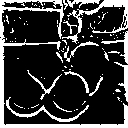

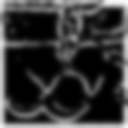

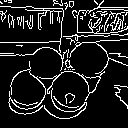

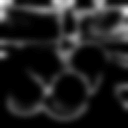

255


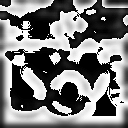

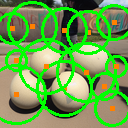

13


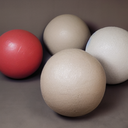

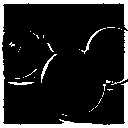

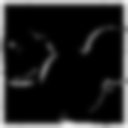

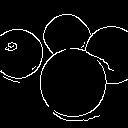

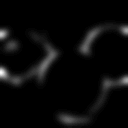

255


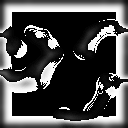

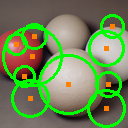

10


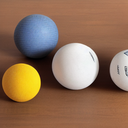

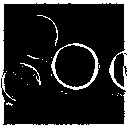

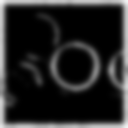

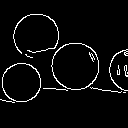

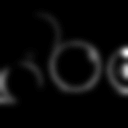

255


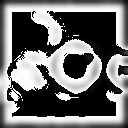

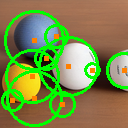

10


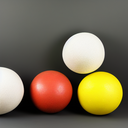

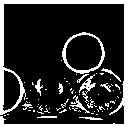

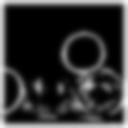

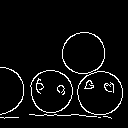

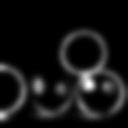

255


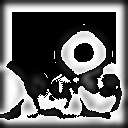

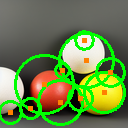

10


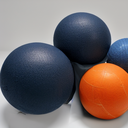

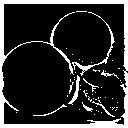

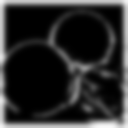

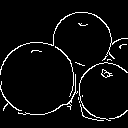

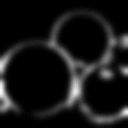

255


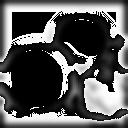

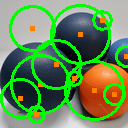

11


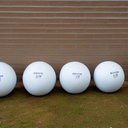

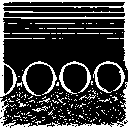

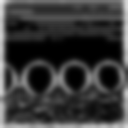

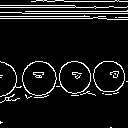

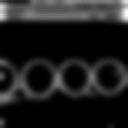

255


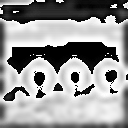

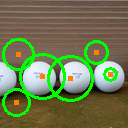

6


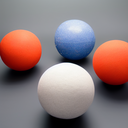

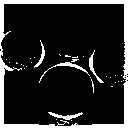

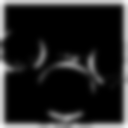

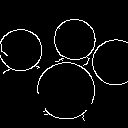

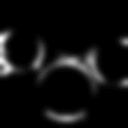

255


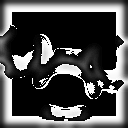

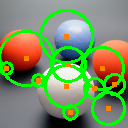

11


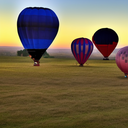

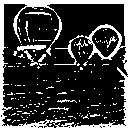

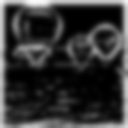

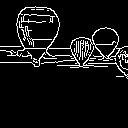

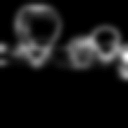

255


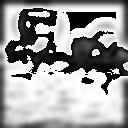

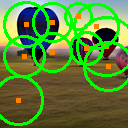

10


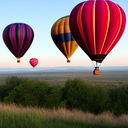

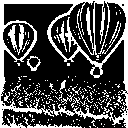

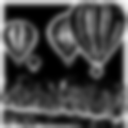

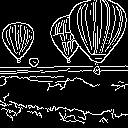

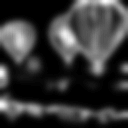

255


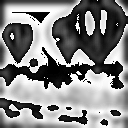

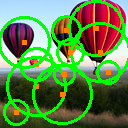

11


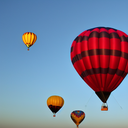

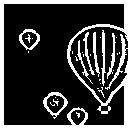

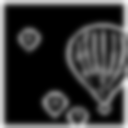

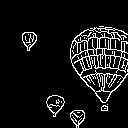

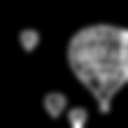

255


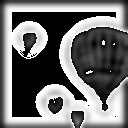

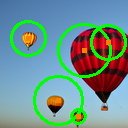

5


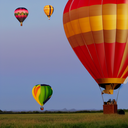

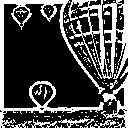

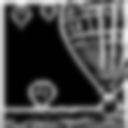

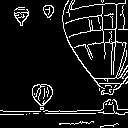

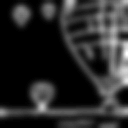

255


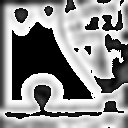

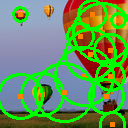

14


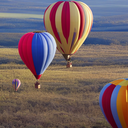

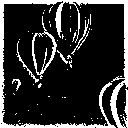

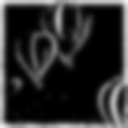

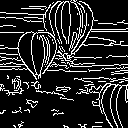

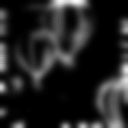

255


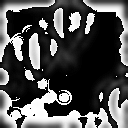

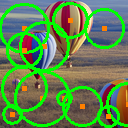

12


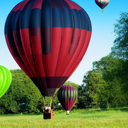

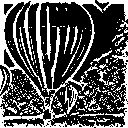

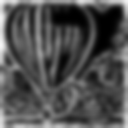

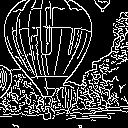

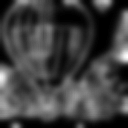

255


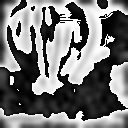

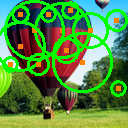

13


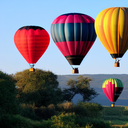

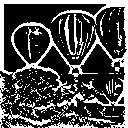

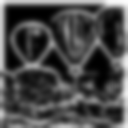

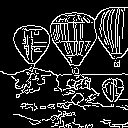

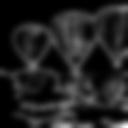

255


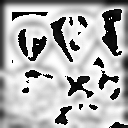

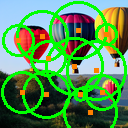

12


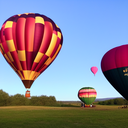

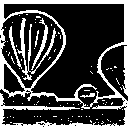

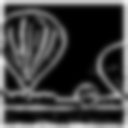

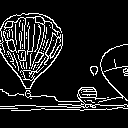

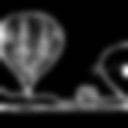

255


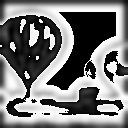

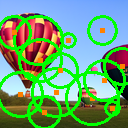

13


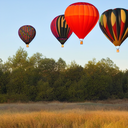

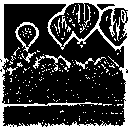

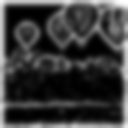

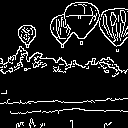

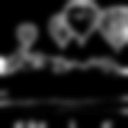

255


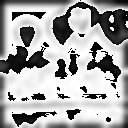

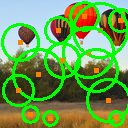

14


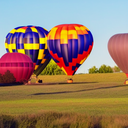

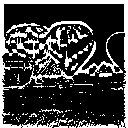

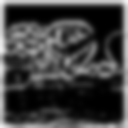

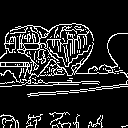

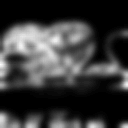

255


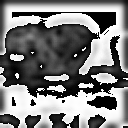

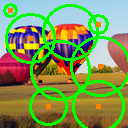

8


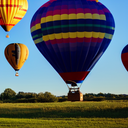

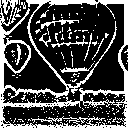

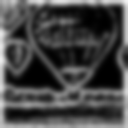

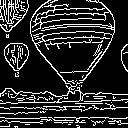

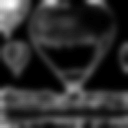

255


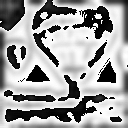

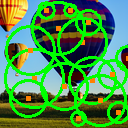

15


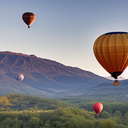

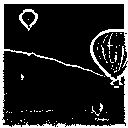

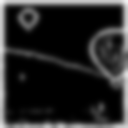

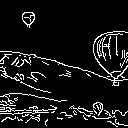

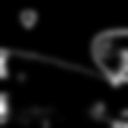

255


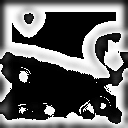

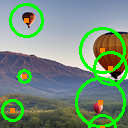

7


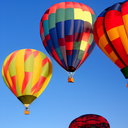

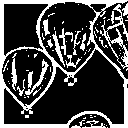

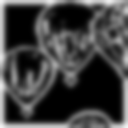

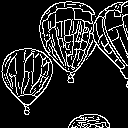

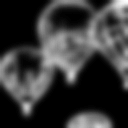

255


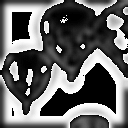

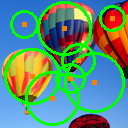

8


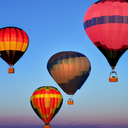

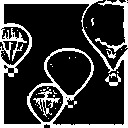

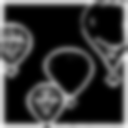

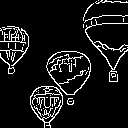

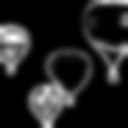

255


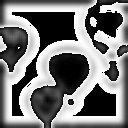

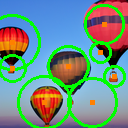

8


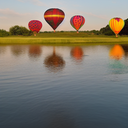

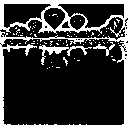

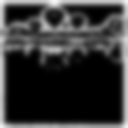

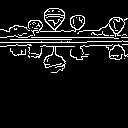

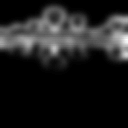

255


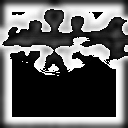

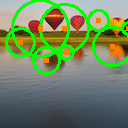

8


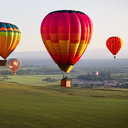

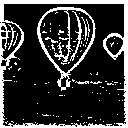

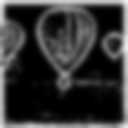

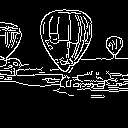

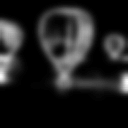

255


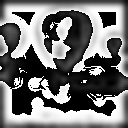

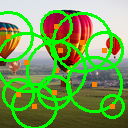

12


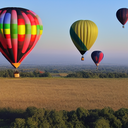

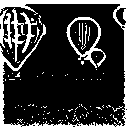

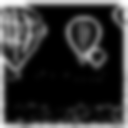

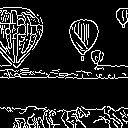

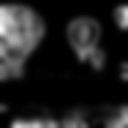

255


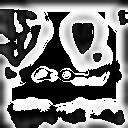

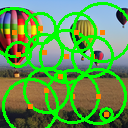

14


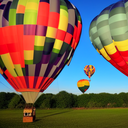

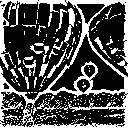

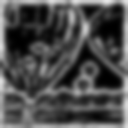

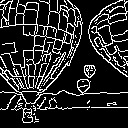

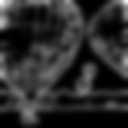

255


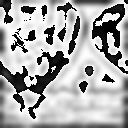

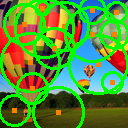

15


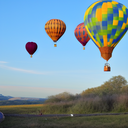

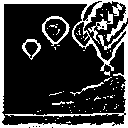

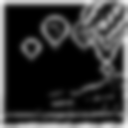

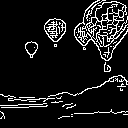

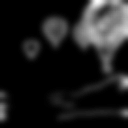

255


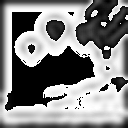

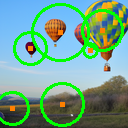

6


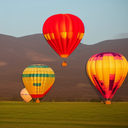

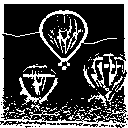

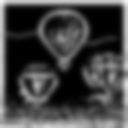

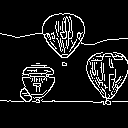

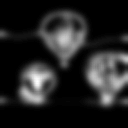

255


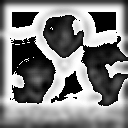

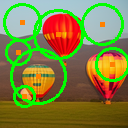

7


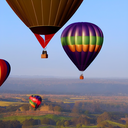

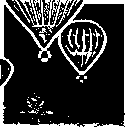

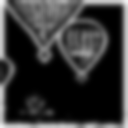

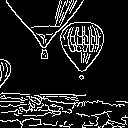

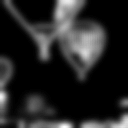

255


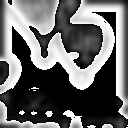

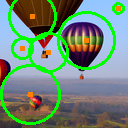

6


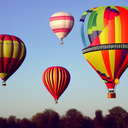

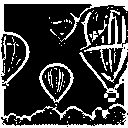

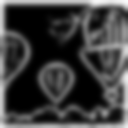

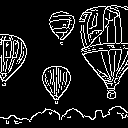

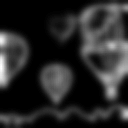

255


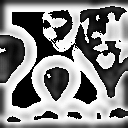

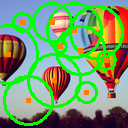

11


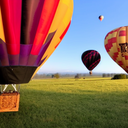

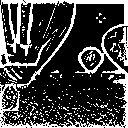

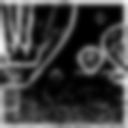

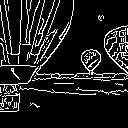

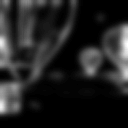

255


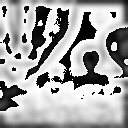

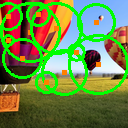

11


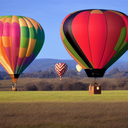

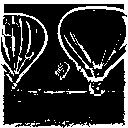

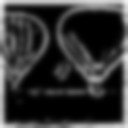

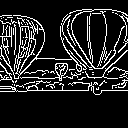

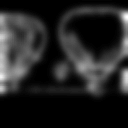

255


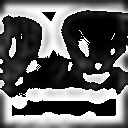

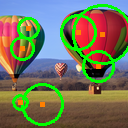

7


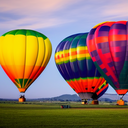

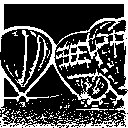

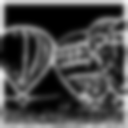

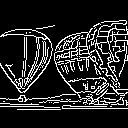

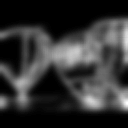

255


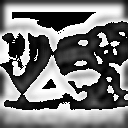

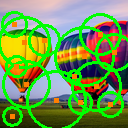

14


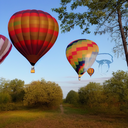

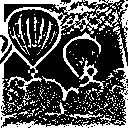

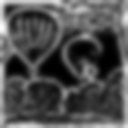

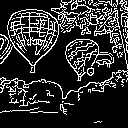

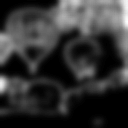

255


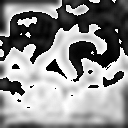

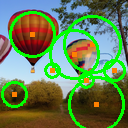

8


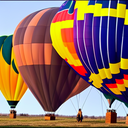

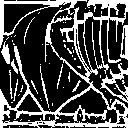

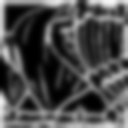

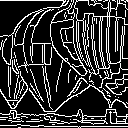

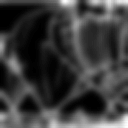

255


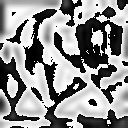

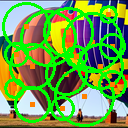

16


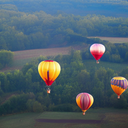

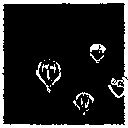

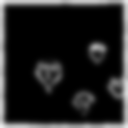

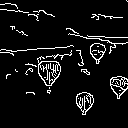

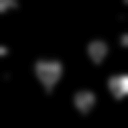

255


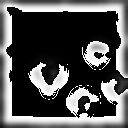

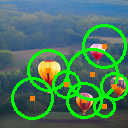

8


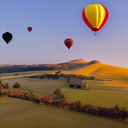

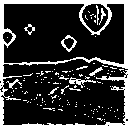

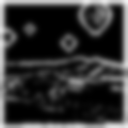

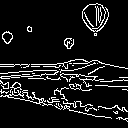

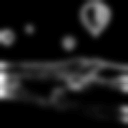

255


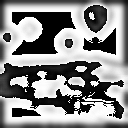

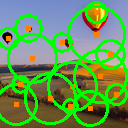

15


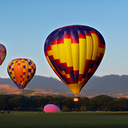

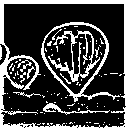

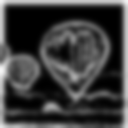

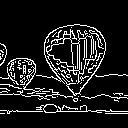

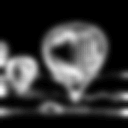

255


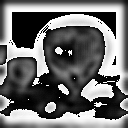

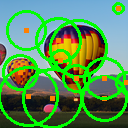

12


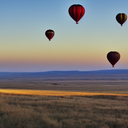

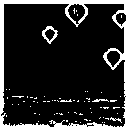

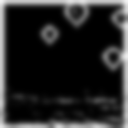

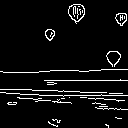

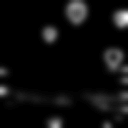

255


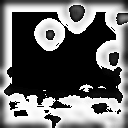

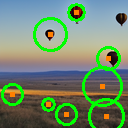

8


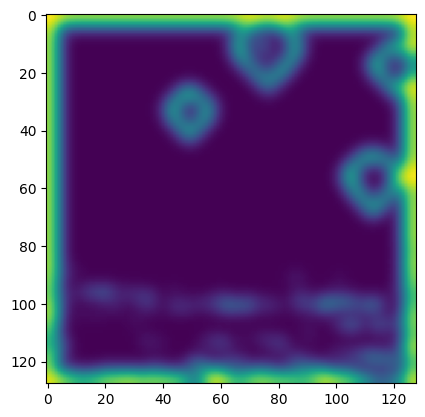

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image


# To import specular reflection removal module
# Downloaded from Github, now in Google Drive locally
from google.colab import drive
drive.mount('/content/drive')
import sys
# Append the directory to your python path using sys
sys.path.append('/content/drive/MyDrive/countingAI/')
# Import the module
import specularity as spc

folder = '/content/drive/MyDrive/countingAI/data_dirs/4/'



def multiply_and_renormalize(img1, img2):
    # Convert images to numpy arrays
    img1_array = np.array(img1, dtype=np.float32)
    img2_array = np.array(img2, dtype=np.float32)

    # Multiply the images
    product = img1_array * img2_array

    # Renormalize the pixel values to the range 0-255
    product = (product - product.min()) / (product.max() - product.min()) * 255

    product = product.astype(np.uint8)

    # Convert back to PIL Image
    product_img = Image.fromarray(product)
    product_img = product

    return product_img






for filename in os.listdir(folder):
    if filename.endswith(".png"): # or filename.endswith(".jpg"):  # Add more extensions if needed
        img_path = os.path.join(folder, filename)

        #img_path = '/content/drive/MyDrive/countingAI/21/eight_bocce_balls_W7HFYX90_sm.png'
        #img_path = '/content/drive/MyDrive/countingAI/21/eight_bocce_balls_W7HMJCB0_sm.png'
        #img_path = '/content/drive/MyDrive/countingAI/data_dirs/10/eight_bocce_balls_W7H6HOQ0_sm.png'

        img = cv2.imread(img_path)
        output = img.copy()
        cv2_imshow(img)
        #cv2.waitKey(0)


        # Remove specular reflections

        if False:
          ### SPECULARITY REMOVAL CODE
          # load the image, clone it for output, and then convert it to grayscale
          image = cv2.imread(img_path)
          output = image.copy()
          #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

          img = cv2.imread(img_path)

          gray_img = spc.derive_graym(img_path)

          r_img = m_img = np.array(gray_img)

          rimg = spc.derive_m(img, r_img)
          s_img = spc.derive_saturation(img, rimg)
          spec_mask = spc.check_pixel_specularity(rimg, s_img)
          enlarged_spec = spc.enlarge_specularity(spec_mask)

          # use opencv's inpaint methods to remove specularity
          radius = 12
          telea = cv2.inpaint(img, enlarged_spec, radius, cv2.INPAINT_TELEA)
          ns = cv2.inpaint(img, enlarged_spec, radius, cv2.INPAINT_NS)

          img = telea

          plt.imshow(img)
          cv2_imshow(img)
          cv2.waitKey(0)




        # Apply blur and make grayscale

        if True:
          blur_hor = cv2.filter2D(img[:, :, 0], cv2.CV_32F, kernel=np.ones((11,1,1), np.float32)/11.0, borderType=cv2.BORDER_CONSTANT)
          blur_vert = cv2.filter2D(img[:, :, 0], cv2.CV_32F, kernel=np.ones((1,11,1), np.float32)/11.0, borderType=cv2.BORDER_CONSTANT)
          mask = ((img[:,:,0]>blur_hor*1.2) | (img[:,:,0]>blur_vert*1.2)).astype(np.uint8)*255

          plt.imshow(mask)
          cv2_imshow(mask)
          cv2.waitKey(0)


        # Apply Gaussian blur

        if True:
          blur = cv2.GaussianBlur(mask,(17,17),0)

          plt.imshow(blur)
          cv2_imshow(blur)
          cv2.waitKey(0)

          mask = blur


        # Sobel Edge Detection

        if False:
          # Sobel edge detection
          edges = cv2.Canny(image=mask, threshold1=100, threshold2=200)
          sobelxy = cv2.Sobel(src=mask, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
          abs_sobel64 = np.absolute(sobelxy)
          sobel_8u = np.uint8(abs_sobel64)
          edges = sobel_8u

          # Display Edge Detection Image
          cv2_imshow(edges)
          cv2.waitKey(0)



        # Canny Edge Detection

        if True:
          edges = cv2.Canny(image=img, threshold1=100, threshold2=200)

          # Display Edge Detection Image
          cv2_imshow(edges)
          cv2.waitKey(0)



        # Multiply and normalize, then blur again

        prodImg = multiply_and_renormalize(mask, edges)
        prodImgBlur = cv2.GaussianBlur(prodImg,(19,19),0)


        # Stretch grayscale pixel values to fill range of 0 to 255

        if True:
          imArray = np.array(prodImgBlur, dtype=np.float32)
          # Find the minimum and maximum pixel values
          min_val = np.min(imArray)
          max_val = np.max(imArray)
          stretched = (imArray - min_val) / (max_val - min_val) * 255
          stretched_img = np.asarray(stretched, dtype=np.uint8)


        #equalized_img = cv2.equalizeHist(stretched_img)
        #equalized_img = cv2.equalizeHist(np.asarray(prodImgBlur, dtype=np.uint8))
        # Display Equalized Image
        #cv2_imshow(equalized_img)
        #cv2.waitKey(0)

        cv2_imshow(stretched_img)
        #cv2.waitKey(0)

        #Detect circles in the image

        # orig. = mask, can also use edges
        circle_input_im = stretched_img #stretched_img


        #circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, param1=40,minRadius=10,maxRadius=35)
        circles = cv2.HoughCircles(circle_input_im,
                                  cv2.HOUGH_GRADIENT,
                                  minDist=20,
                                  dp=1,
                                  param1=150,  #orig. 150
                                  param2=12,
                                  minRadius=4,
                                  maxRadius=30)




        # Draw circles superimposed on orig. image

        #print(len(circles[0][0]))
        # ensure at least some circles were found
        if circles is not None:
            # convert the (x, y) coordinates and radius of the circles to integers
            circles = np.round(circles[0, :]).astype("int")
            # count = count+1
            # print(count)

            # width of squares to draw in circle centers
            rect_w = 2

            # loop over the (x, y) coordinates and radius of the circles
            for (x, y, r) in circles:
                # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
                cv2.circle(output, (x, y), r, (0, 255, 0), 2)
                cv2.rectangle(output, (x - rect_w, y - rect_w), (x + rect_w, y + rect_w), (0, 128, 255), -1)

            # show the output image
            # cv2.imshow("output", np.hstack([output]))
            #cv2.imwrite('output.jpg',np.hstack([output]),[cv2.IMWRITE_JPEG_QUALITY, 70])
            #cv2.waitKey(0)
            #plt.imshow(output)
            cv2_imshow(output)
            print(len(circles))
